In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.polynomial.polynomial as poly
from tqdm import tqdm

In [3]:
def CriticalPoints(f):
    #This function takes a polynomial f and returns its critical points (which can be complex).
    fprime = poly.polyder(f)
    return poly.polyroots(fprime)

100%|██████████| 101/101 [00:00<00:00, 201.75it/s]


Text(0, 0.5, 'p2')

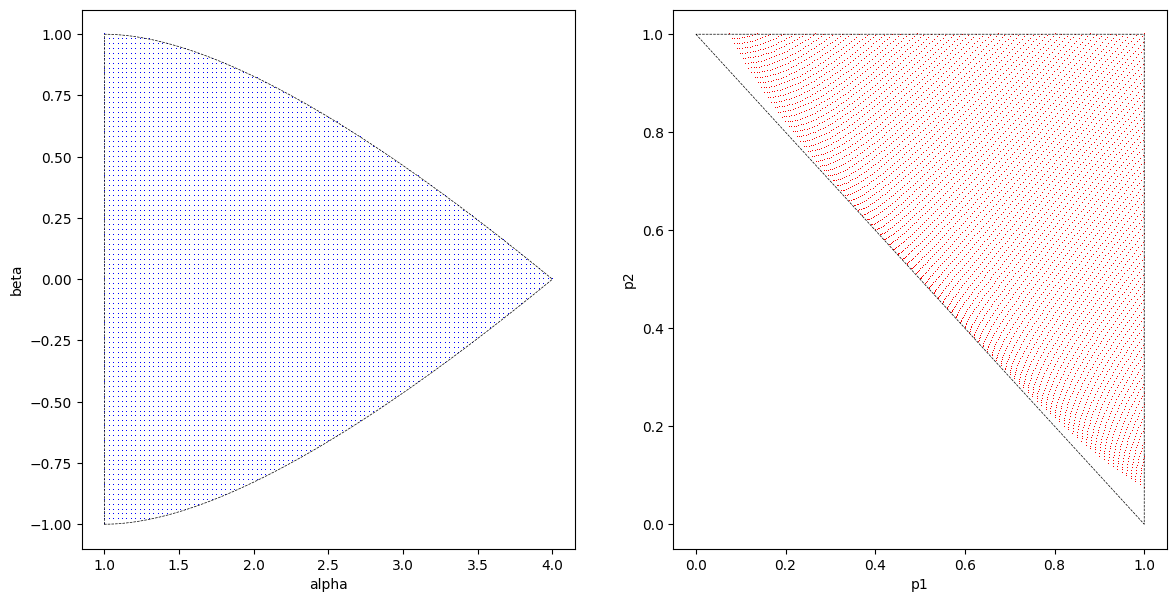

In [18]:
M = np.linspace(1,4,101)
Y = np.linspace(-1,1,101)
input_points = []
Z = []
A = []
for ms, m in enumerate(tqdm(M)):
    #Computing the parameter space for cubic polynomials
    maxn = 2*np.sqrt(abs(m)) - abs(m)
    N = [y for y in Y if abs(y) <= maxn]
    input_points += [[m,n] for n in N]
    for ns, n in enumerate(N):
        #Computing the critical points of the polynomials in the parameter space
        f = (-n,1-m,n,m)
        C = CriticalPoints(f)
        #Finding the value of the polynomial at its real critical points (the critical values)
        C = [poly.polyval(c.real,f) for c in C[np.isreal(C)]]
        A += [[C[0], C[1]]]

#initialising figures
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(14,7))

#In these figures, note the dotted lines.  These denote the theoretical boundaries of the spaces which are being discretised by the above algorithm

#Plotting the raw parameter space of cubic polynomials
parameter_space = np.asarray(input_points)
ax1.plot(*parameter_space.T,'b,')
ax1.plot(M,2*np.sqrt(M) - M,'k--',lw=0.5)
ax1.plot(M,-(2*np.sqrt(M) - M),'k--',lw=0.5)
ax1.plot([1,1],[-1,1],'k--',lw=0.5)
ax1.set_xlabel('alpha')
ax1.set_ylabel('beta')

#Calculating the space of possible critical values
crit_vals = np.asarray([[(1 + x)/2,(1 - y)/2] for [x,y] in A])
ax2.plot(*crit_vals.T,'r,')
ax2.plot([0,1,1,0],[1,0,1,1],'k--',lw=0.5)
ax2.set_xlabel('p1')
ax2.set_ylabel('p2')

In [20]:
def Orbit(x,f,N): 
    #Generates the first N iterates of a point x under the polynomial f
    O = np.zeros(N)
    O[0] = x
    for n in range(1,N):
        O[n] = poly.polyval(O[n-1],f)
    return O

In [94]:
def Itinerary(x,f,N,critical_points):
    #Computes the itinerary of the point x under f
    O = Orbit(x,f,N)
    l = len(critical_points)
    I = []
    for y in O:
        for i, c in enumerate(critical_points):
            #the nth entry in the itinerary is determined by whether a point is below or equal to a given critical point at time n
            if y < c:
                I += [f'I{i+1}']
                break
            elif y == c:
                I += [f'C{i+1}']
                break
        else:
            I += [f'I{l+1}']
    
    return I

In [83]:
def MinMax(critnum,shape,f,N,critical_points):
    #This computes the min-max sequences according to the Amigo et al. 2014 paper
    fci = poly.polyval(critical_points[critnum-1],f)
    I = Itinerary(fci,f,N,critical_points)
    W = []
    if critnum%2 == 1:
        if shape == 1:
            W += [f'M{I[0]}']
        else:
            W += [f'm{I[0]}']
    else:
        if shape == 1:
            W += [f'm{I[0]}']
        else:
            W += [f'M{I[0]}']
    for k in range(1,len(I)):
        #print(I[k])
        for i in range(len(critical_points)):
            if (W[-1] == f'mC{i+1}' or W[-1] == f'MC{i+1}') and i%2 == 0:
                if shape == 1:
                    W += [f'M{I[k]}']
                else:
                    W += [f'm{I[k]}']
                break
            elif (W[-1] == f'mC{i+1}' or W[-1] == f'MC{i+1}') and i%2 == 1:
                if shape == 1:
                    W += [f'm{I[k]}']
                else:
                    W += [f'M{I[k]}']
                break
        for i in range(len(critical_points)+1):
            if (W[-1] == f'mI{i+1}' and i%2 == 0) or (W[-1] == f'MI{i+1}' and i%2 == 1):
                if shape == 1:
                    W += [f'm{I[k]}']
                else:
                    W += [f'M{I[k]}']
                break
            elif (W[-1] == f'mI{i+1}' and i%2 == 1) or (W[-1] == f'MI{i+1}' and i%2 == 0):
                if shape == 1:
                    W += [f'M{I[k]}']
                else:
                    W += [f'm{I[k]}']
                break
    
    return W

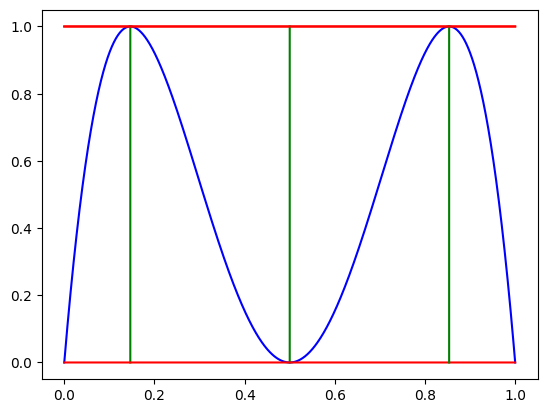

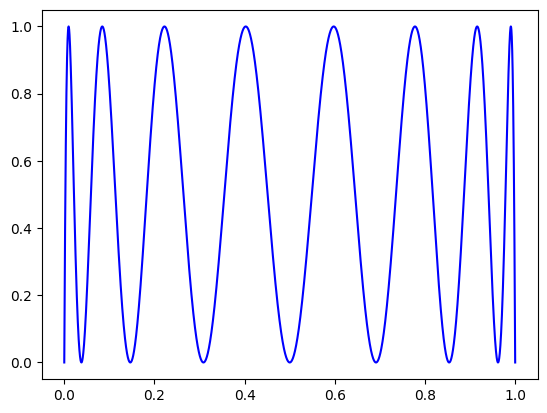

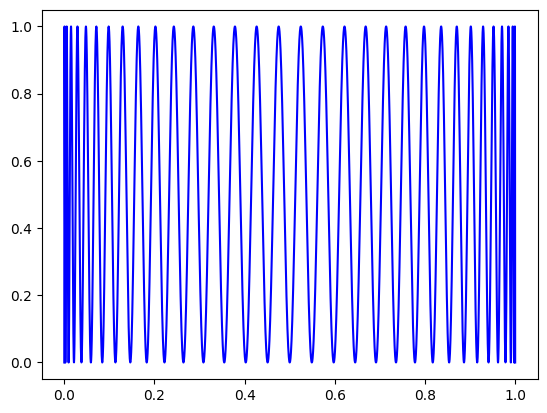

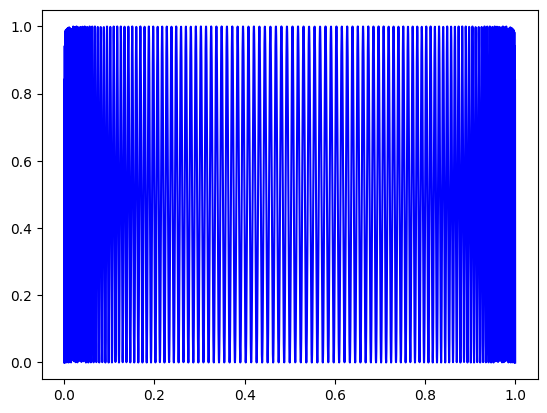

In [84]:
m = 4
n = 4
f = (0, m*n, -m*n - m*n*n, 2*m*n*n, -m*n*n)
C = CriticalPoints(f)
C = [x.real for x in C[np.isreal(C)]]
V = [poly.polyval(c,f) for c in C]
xlin = np.linspace(0,1,5001)
Clines = np.asarray([c*np.ones(len(xlin)) for c in C])
Vlines = np.asarray([v*np.ones(len(xlin)) for v in V])
fn = [poly.polyval(x,f) for x in xlin]
plt.figure()
plt.plot(xlin,fn,'b')
for i in range(len(V)):
    #green lines correspond to the critical points
    plt.plot(Clines[i], xlin, 'g')
    #red lines correspond to the critical values
    plt.plot(xlin, Vlines[i], 'r')
for n in range(3):
    #plotting compositions of the polynomial f
    fn = [poly.polyval(x,f) for x in fn]
    plt.figure()
    plt.plot(xlin,fn,'b')

In [85]:
def MinMaxSequences(f,shape,l,N,critical_points):
    W = []
    for i in range(1,l+1):
        S = MinMax(i,shape,f,N,critical_points)
        W += [S]
    return W

In [86]:
def BadSymbols(l):
    #This function computes the bad symbols which we will use to determine whether to add values associated with the min-max sequences to our topological entropy approximation or not
    B = []
    for n in range(1,l+1):
        Bi = []
        for m in range(1,l+1):
            if m <= n:
                Bi += [f'MI{m}',f'MC{m}']
            if m >= n:
                Bi += [f'mC{m}',f'mI{m+1}']
        B += [Bi]
    return B

In [87]:
def NextKvi(Kvi, v, MinMaxSymbols, BadSymbols, l):
    for i in range(l):
        KviNextEntry = []
        for k in range(l):
            if MinMaxSymbols[k][v - 1] in BadSymbols[i]:
                KviNextEntry += [[k, v]]
        Kvi[i] += KviNextEntry
    return Kvi

In [88]:
def CapitalSvi(svi,Kvi,v,l):
    Svi = []
    for i in range(l):
        if Kvi[i] == []:
            Svi += [0]
        else:
            L = [[x,v-y] for [x,y] in Kvi[i]]
            Svi += [2*sum([svi[j][k] for [k,j] in L])]
    return Svi

In [89]:
def Nextsvi(svi, sum_sv, Svi):
    svi += [[1 + sum_sv - Svi[i] for i in range(len(Svi))]]
    return svi

In [90]:
def TopologicalEntropy(f, shape, critical_points, bad_symbols, epsilon = 1e-4, nmax = 100):
    #Preparation / initialisation
    l = len(critical_points)
    if l == 0:
        return 10*epsilon
    s0i = np.ones(l)
    s0 = l
    W = MinMaxSequences(f, shape, l, nmax+1, critical_points)
    Kvi = []
    for i in range(l):
        Kvientry = []
        for k in range(l):
            if W[k][0] in bad_symbols[i]:
                Kvientry += [[k,1]]
        Kvi += [Kvientry]
    S1i = []
    for i in range(l):
        if Kvi[i] == []:
            S1i += [0]
        else:
            L = [1-y for [_,y] in Kvi[i]]
            S1i += [2*sum([s0i[j] for j in L])]
    S1 = sum(S1i)
    s1i = np.zeros(l)
    for i in range(l):
        s1i[i] = 1 + l - S1i[i]
    s1 = l*(1 + s0) - S1
    #Preparation ends here

    #Here begins the bulk of the approximation algorithm
    #initialising approximation variables
    Svi = S1i
    Sv = S1
    svi = [s0i,s1i]
    sum_sv = s0+s1
    sv = s1
    h0 = 0
    
    for v in range(2, nmax + 1):
        #iterating the algorithm
        Kvi = NextKvi(Kvi, v, W, bad_symbols, l)
        Svi = CapitalSvi(svi, Kvi, v, l)
        Sv = sum(Svi)
        svi = Nextsvi(svi, sum_sv, Svi)
        sv = l*(1 + sum_sv) - Sv
        sum_sv += sv #We don't actually need to store the entire list of sv values, just the latest value and the sum of all values so far
        h1 = np.log((sv + Sv)/l)/v
        
        if abs(h1 - h0) <= epsilon: #return our approximation if the current and previous approximations are close enough
            return h1
        elif not (np.isnan(h1) or np.isinf(h1)): #else we start again
            h0 = h1
        
    return h1

[-0.60549886 -0.06116781]
Critical Points: [-0.6054988603092419, -0.06116780635742465] 
Number of modes: 2
['I3', 'I1', 'I1', 'I1', 'I1', 'I1', 'I1', 'I1', 'I1', 'I1']
The topological entropy of f is: 0.0010465855761028079


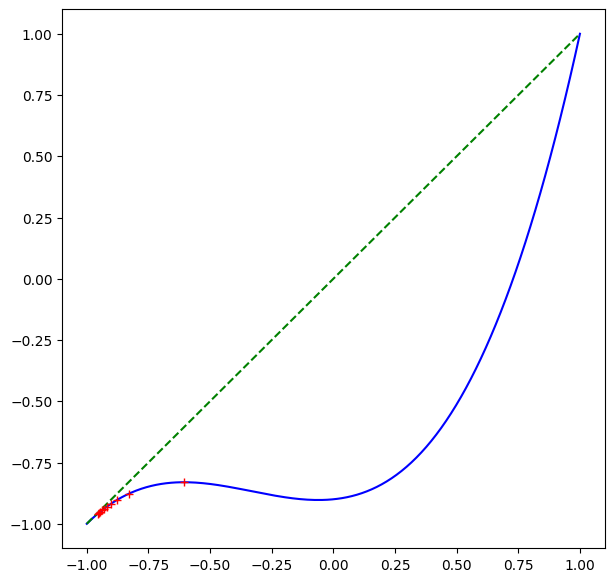

In [96]:
#Test evaluation of the TopologicalEntropy function

#initialisation
bad_symbols = BadSymbols(3)
m = 0.9
n = 0.9
f = (-n,1-m,n,m)
shape = 1
#printing off some values
C = CriticalPoints(f)
print(C)
C = [x.real for x in C[np.isreal(C)]]
l = len(C)
print('Critical Points:',C,'\nNumber of modes:',l)

#computing the polynomial curve and the orbits for plotting
xlin = np.linspace(-1,1,200)
F = [poly.polyval(x,f) for x in xlin]
O = Orbit(C[0],f,10)
V = Orbit(poly.polyval(C[0],f),f,10)
I = Itinerary(0,f,10,C)
print(I)

#computing the topological entropy of f
h = TopologicalEntropy(f, shape, C, bad_symbols, epsilon = 1e-7, nmax = 50000)
print('The topological entropy of f is:', h)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(7,7))
ax.plot(xlin, F, 'b')
ax.plot(xlin,xlin,'g--')
ax.plot(O,V,'r+')
plt.show()

In [97]:
def DrawCubicEntropy(shape = 1, Precision = 100, epsilon = 1e-3, nmax=2000):
    if shape == 1:
        M = np.linspace(2,4,Precision+1)
    elif shape == -1:
        M = np.linspace(-4,-2,Precision+1)
    Y = np.linspace(-1,1,Precision+1)
    A = []
    bad_symbols = BadSymbols(3)
    for m in tqdm(M):
        maxn = 2*np.sqrt(abs(m)) - abs(m)
        N = [y for y in Y if abs(y) <= maxn]
        for n in N:
            f = (-n, shape-m, n, m)
            C = CriticalPoints(f)
            C = [x.real for x in C[np.isreal(C)]]
            critical_vals = [poly.polyval(c.real,f) for c in C]
            z = TopologicalEntropy(f, shape, C, bad_symbols, epsilon = epsilon, nmax = nmax)
            A += [[critical_vals[0], critical_vals[1], z]]
    if shape == 1:
        lins = np.array([[(1 + x)/2,(1 - y)/2, z] for [x,y,z] in A]).astype(float)
    elif shape == -1:
        lins = np.array([[(1 - x)/2,(1 + y)/2, z] for [x,y,z] in A]).astype(float)
    Mlin = lins[:,0]
    Nlin = lins[:,1]
    Z = lins[:,2]
    fig, ax1 = plt.subplots(figsize=(8,8))
    ax1.tricontour(list(Mlin),list(Nlin),list(Z),20)

100%|██████████| 201/201 [06:52<00:00,  2.05s/it]


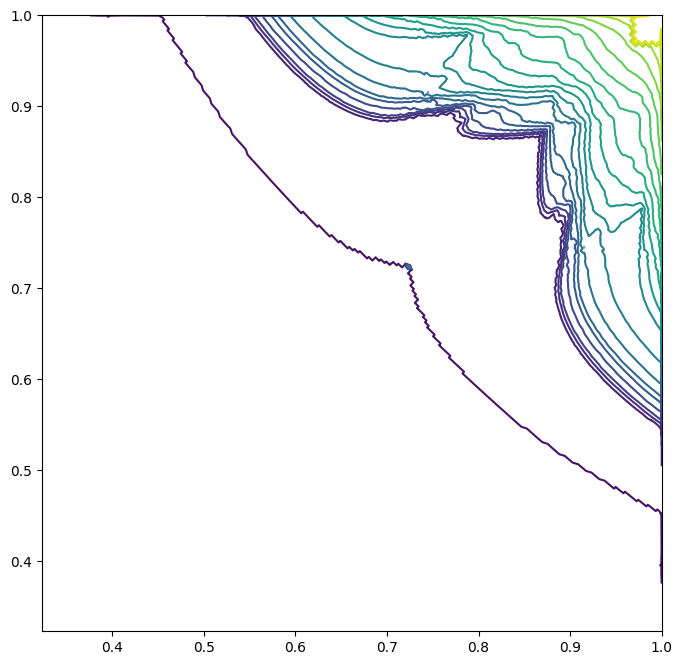

In [98]:
DrawCubicEntropy(shape = 1,Precision = 200, epsilon = 1e-3, nmax = 2000)

In [ ]:
def DrawQuarticEntropy(Precision = 100):
    #This function draws the isentropes for quartic polynomials of the form given by Radulescu's 2008 paper
    X = np.linspace(0,4,Precision+1)
    X1, X2 = np.meshgrid(X,X)
    Z = np.zeros(X1.shape)
    bad_symbols = BadSymbols(4)
    for ms, m in enumerate(tqdm(X)):
        for ns, n in enumerate(X):
            f = (0, m*n, -m*n - m*n*n, 2*m*n*n, -m*n*n)
            C = CriticalPoints(f)
            C = [x.real for x in C[np.isreal(C)]]
            Z[ms,ns] = TopologicalEntropy(f, 1, C, bad_symbols, epsilon = 1e-4, nmax = 5000)
    plt.figure(figsize = (8,8))
    plt.contour(X1,X2,Z,20)

  8%|▊         | 8/101 [00:41<08:48,  5.68s/it]C:\Users\Noah Cockram\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\polynomial\polynomial.py:756: RuntimeWarning: overflow encountered in scalar multiply
  c0 = c[-i] + c0*x
C:\Users\Noah Cockram\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\polynomial\polynomial.py:754: RuntimeWarning: invalid value encountered in scalar multiply
  c0 = c[-1] + x*0
 11%|█         | 11/101 [00:58<08:40,  5.78s/it]C:\Users\Noah Cockram\AppData\Local\Temp\ipykernel_13908\3027908539.py:50: RuntimeWarning: invalid value encountered in log
  h1 = np.log((sv + Sv)/l)/v
100%|██████████| 101/101 [11:48<00:00,  7.01s/it]

708.1811304092407


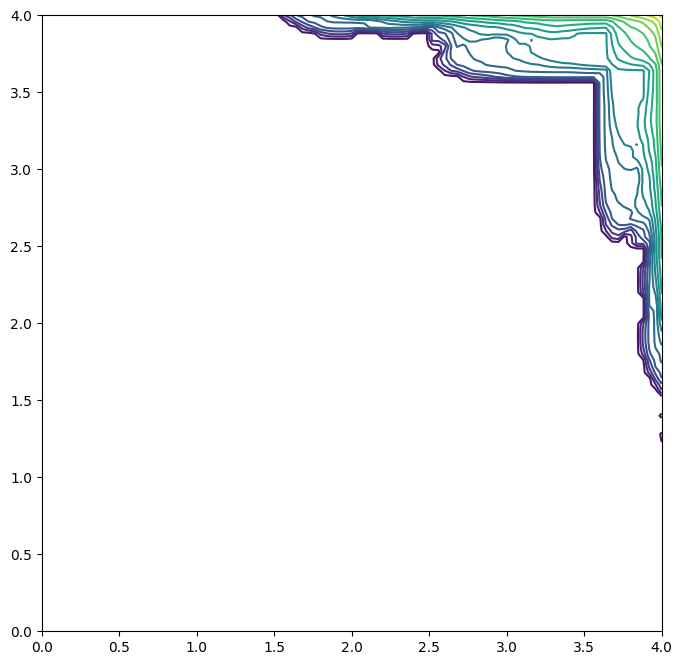

In [ ]:
DrawQuarticEntropy(Precision = 100)